# Denoising autoencoder com regularizador

Vamos mostrar como aprender a estrutura de um autoencoder que faz denoising. 
O autoencoder será do tipo CNN com algumas camadas. Ele terá um regularizador zerando alguns nós na camada CODE. Veja as notas de aula.

Fica como exercício criar um dataset acrescentando um ruído "estruturado" nas imagens 28x28 do MNIST imitando uma marca d'água. Por exemplo, imagine que a marca d'água será um conjunto 4 x 6 de pixels. Escolha uma posição numa buffer 
que impeça a marca d'água sair da imagem. A marca deverá apenas um conjunto de pixels dentro do retângulo 4 x 6 que crie uma imagem distinta (uma cruz, por exemplo). Se você quiser ser criativo, fique a vontade. Por exemplo, usando marcas mais legais e usando um banco de imagens menos simples. 

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt

# o regularizador na acamada CODE precisa do módulo regularizers
from keras import regularizers

In [ ]:
# Load MNIST

(x_train, _), (x_test, _) = mnist.load_data()

# Scaling the values to be floats between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# Adding Gaussian noise N(0, 0.25) at each pixel  (we add 0.5*N(0.1) = N(0, 0.5**2))
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# clipping to assure that the noisy values are between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

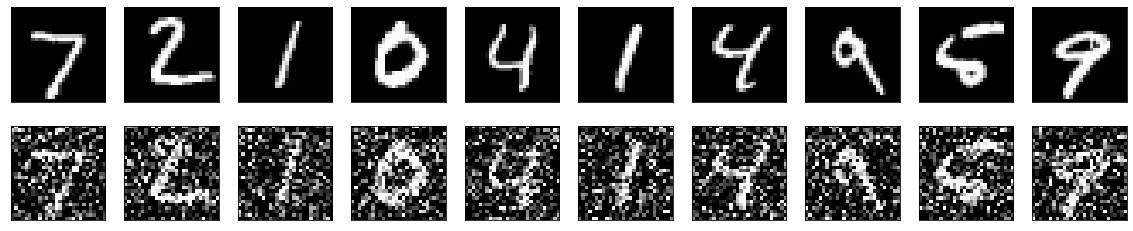

In [ ]:
# Visualizing the noisy values

n = 10   # How many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the noisy version 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input = Input(shape=(28,28,1), name='entrada')
conv = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', name='conv_1')
x = conv(input)
maxp = MaxPooling2D(pool_size=(2,2), padding='same')
x = maxp(x)
# demais camadas, usando callable layers
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_2')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', 
                  name='conv_3', activity_regularizer=regularizers.l1(10e-5))(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# Vamos agora especificar os nós do grafo de camadas associados com o decoder
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', 
                  name='conv_4')(x)
x = UpSampling2D(size=(2,2))(x)
# Demais camadas
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_5')(x)
x = UpSampling2D(size=(2,2))(x)

x = Conv2D(filters=8, kernel_size=(3,3), activation='relu',name='conv_6')(x)
x = UpSampling2D(size=(2,2))(x)

output = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid', name='output')(x)

autoencoder = Model(inputs= input, outputs=output, name='CAE')
autoencoder.summary()

Model: "CAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv_3 (Conv2D)             (None, 7, 7, 8)           584     

In [ ]:
# Compile o modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Treinando o modelo
autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=256)

Epoch 1/15
235/235 [==============================] - 59s 245ms/step - loss: 0.2953
Epoch 2/15
235/235 [==============================] - 60s 257ms/step - loss: 0.2011
Epoch 3/15
235/235 [==============================] - 63s 268ms/step - loss: 0.1804
Epoch 4/15
235/235 [==============================] - 66s 279ms/step - loss: 0.1680
Epoch 5/15
235/235 [==============================] - 60s 254ms/step - loss: 0.1611
Epoch 6/15
235/235 [==============================] - 59s 250ms/step - loss: 0.1568
Epoch 7/15
235/235 [==============================] - 57s 244ms/step - loss: 0.1533
Epoch 8/15
235/235 [==============================] - 57s 242ms/step - loss: 0.1505
Epoch 9/15
235/235 [==============================] - 57s 243ms/step - loss: 0.1482
Epoch 10/15
235/235 [==============================] - 56s 238ms/step - loss: 0.1462
Epoch 11/15
235/235 [==============================] - 56s 238ms/step - loss: 0.1447
Epoch 12/15
235/235 [==============================] - 56s 238ms/step - lo

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

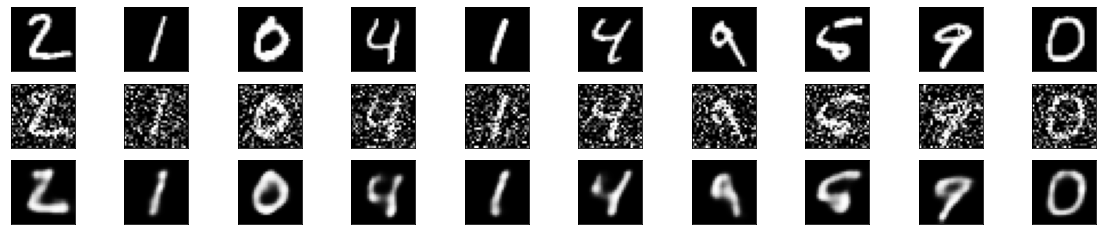

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))  # imagens originais, sem ruído
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy test images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()